In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
from pathlib import Path
import pandas as pd

# Go 2 levels up from current notebook location to project root
ROOT = Path.cwd().parents[1]

# Define correct paths
EVAL_PATH = ROOT / "feat_eng" / "datasets_feat_eng" / "cleaned_feat_eng" / "eval_cleaned_feat_eng_1.csv"
ADDR_PATH = ROOT / "datasets" / "cleaned" / "adresses.csv"
INC_PATH  = ROOT / "datasets" / "cleaned" / "interventions_cleaned_with_has_fire.csv"

# Debug file presence
print("[eval exists?]", EVAL_PATH.exists(), " ➜ ", EVAL_PATH)
print("[addr exists?]", ADDR_PATH.exists(), " ➜ ", ADDR_PATH)
print("[inc exists?] ", INC_PATH.exists(), " ➜ ", INC_PATH)

# Load data
if not EVAL_PATH.exists():
    raise FileNotFoundError(f"❌ EVAL file not found at {EVAL_PATH}")
eval_df = pd.read_csv(EVAL_PATH, dtype=str)
addr_df = pd.read_csv(ADDR_PATH, dtype=str)
inc_df  = pd.read_csv(INC_PATH)







[eval exists?] True  ➜  C:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6-main\feat_eng\datasets_feat_eng\cleaned_feat_eng\eval_cleaned_feat_eng_1.csv
[addr exists?] True  ➜  C:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6-main\datasets\cleaned\adresses.csv
[inc exists?]  True  ➜  C:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6-main\datasets\cleaned\interventions_cleaned_with_has_fire.csv


In [3]:
# ✅ Load data
eval_df = pd.read_csv(EVAL_PATH, dtype=str)
addr_df = pd.read_csv(ADDR_PATH, dtype=str)
inc_df  = pd.read_csv(INC_PATH)

In [4]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512288 entries, 0 to 512287
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ID_UEV                  512288 non-null  object
 1   CIVIQUE_DEBUT           512288 non-null  object
 2   CIVIQUE_FIN             512288 non-null  object
 3   NOM_RUE                 512288 non-null  object
 4   SUITE_DEBUT             134705 non-null  object
 5   MUNICIPALITE            512288 non-null  object
 6   ETAGE_HORS_SOL          512288 non-null  object
 7   NOMBRE_LOGEMENT         512288 non-null  object
 8   ANNEE_CONSTRUCTION      512288 non-null  object
 9   CODE_UTILISATION        512288 non-null  object
 10  LETTRE_DEBUT            3254 non-null    object
 11  LETTRE_FIN              6419 non-null    object
 12  LIBELLE_UTILISATION     512288 non-null  object
 13  CATEGORIE_UEF           512288 non-null  object
 14  MATRICULE83             512288 non-n

In [5]:
# 🔥 Filter only incidents involving fire
inc_df = inc_df[
    inc_df["DESCRIPTION_GROUPE"].str.contains("INCENDIE", case=False, na=False)
]

In [6]:

# --- Clean and prepare eval_df ---
eval_df["CIVIQUE_DEBUT"] = eval_df["CIVIQUE_DEBUT"].str.strip().astype(int)
eval_df["NOM_RUE_CLEAN"] = eval_df["NOM_RUE"].str.extract(r"^(.*?)(?:\s+\(.*)?$")[0].str.lower().str.strip()

In [7]:
# ✅ Save original now that NOM_RUE_CLEAN exists
original_eval_df = eval_df.copy()

In [8]:
# --- Clean and prepare addr_df ---
addr_df["ADDR_DE"] = addr_df["ADDR_DE"].astype(int)
addr_df["NOM_RUE_CLEAN"] = (
    addr_df["GENERIQUE"].str.lower().str.strip() + " " +
    addr_df["SPECIFIQUE"].str.lower().str.strip()
)

In [9]:
# --- Merge eval_df with addr_df to get coordinates ---
eval_with_coords = pd.merge(eval_df, addr_df,
                            left_on=["CIVIQUE_DEBUT", "NOM_RUE_CLEAN"],
                            right_on=["ADDR_DE", "NOM_RUE_CLEAN"],
                            how="left")

In [10]:
# --- Remove rows without coordinates before spatial join ---
eval_with_coords = eval_with_coords.dropna(subset=["LONGITUDE", "LATITUDE"])

In [11]:
# --- Convert to GeoDataFrame ---
eval_gdf = gpd.GeoDataFrame(
    eval_with_coords,
    geometry=gpd.points_from_xy(eval_with_coords["LONGITUDE"].astype(float),
                                 eval_with_coords["LATITUDE"].astype(float)),
    crs="EPSG:4326"
)

In [12]:
# --- Convert incidents to GeoDataFrame ---
inc_df["CREATION_DATE_TIME"] = pd.to_datetime(inc_df["CREATION_DATE_TIME"], errors='coerce')
incident_gdf = gpd.GeoDataFrame(
    inc_df,
    geometry=gpd.points_from_xy(inc_df["LONGITUDE"], inc_df["LATITUDE"]),
    crs="EPSG:4326"
)

In [13]:
# --- Project both to meters for spatial operations ---
eval_gdf = eval_gdf.to_crs(epsg=32188)
incident_gdf = incident_gdf.to_crs(epsg=32188)
incident_gdf["buffer"] = incident_gdf.geometry.buffer(100)
incident_buffer_gdf = incident_gdf.set_geometry("buffer")

In [14]:
# --- Spatial join: match each home to nearby fires ---
joined = gpd.sjoin(eval_gdf, incident_buffer_gdf, predicate='within', how='inner')
joined = joined.rename(columns={"CREATION_DATE_TIME": "fire_date"})
joined["fire"] = True

In [15]:
# --- Extract relevant fire info ---
#fire_records = joined[["ID_UEV", "fire_date"]].copy()
#fire_records["fire"] = True

In [16]:
print(joined.columns.tolist())


['ID_UEV', 'CIVIQUE_DEBUT', 'CIVIQUE_FIN', 'NOM_RUE', 'SUITE_DEBUT', 'MUNICIPALITE', 'ETAGE_HORS_SOL', 'NOMBRE_LOGEMENT', 'ANNEE_CONSTRUCTION', 'CODE_UTILISATION', 'LETTRE_DEBUT', 'LETTRE_FIN', 'LIBELLE_UTILISATION', 'CATEGORIE_UEF', 'MATRICULE83', 'SUPERFICIE_TERRAIN', 'SUPERFICIE_BATIMENT', 'NO_ARROND_ILE_CUM', 'AGE_BATIMENT', 'RATIO_SURFACE', 'DENSITE_LOGEMENT', 'HAS_MULTIPLE_LOGEMENTS', 'FIRE_FREQUENCY_ZONE', 'NOM_RUE_CLEAN', 'ID_ADRESSE', 'TEXTE', 'SPECIFIQUE', 'ORIENTATION', 'LIEN', 'HAUTEUR', 'GENERIQUE', 'ANGLE', 'ADDR_DE', 'ADDR_A', 'X', 'Y', 'LONGITUDE_left', 'LATITUDE_left', 'geometry', 'index_right', 'INCIDENT_NBR', 'fire_date', 'INCIDENT_TYPE_DESC', 'DESCRIPTION_GROUPE', 'CASERNE', 'NOM_VILLE', 'NOM_ARROND', 'DIVISION', 'NOMBRE_UNITES', 'LONGITUDE_right', 'LATITUDE_right', 'geometry_right', 'fire']


✅ Cleaned Feature Selection Strategy for Modeling Fire Risk
🔹 Variables to KEEP in Final Dataset (for modeling + interpretation)

| Feature                  | Use in Modeling `X` | Notes                                       |
| ------------------------ | ------------------- | ------------------------------------------- |
| `ID_UEV`                 | ❌                   | Keep in dataset for reference only          |
| `MUNICIPALITE`           | ✅                   | Categorical feature; encode                 |
| `ETAGE_HORS_SOL`         | ✅                   | Numerical                                   |
| `NOMBRE_LOGEMENT`        | ✅                   | Numerical                                   |
| `ANNEE_CONSTRUCTION`     | ✅                   | Convert to `AGE_BATIMENT`                   |
| `CODE_UTILISATION`       | ✅                   | One-hot encode or group                     |
| `LIBELLE_UTILISATION`    | ❌                   | Drop from `X`, interpret only               |
| `CATEGORIE_UEF`          | ✅                   | One-hot encode                              |
| `SUPERFICIE_TERRAIN`     | ✅                   | Numerical                                   |
| `SUPERFICIE_BATIMENT`    | ✅                   | Numerical                                   |
| `NO_ARROND_ILE_CUM`      | ✅ or ❌              | Optional — based on spatial policy interest |
| `LONGITUDE` / `LATITUDE` | ✅                   | Keep for feature engineering or clustering  |
| `fire`                   | 🎯 Target (`y`)     | Binary target                               |


🧹 Features to DROP from Dataset (or only use for merging)

| Feature             | Reason for Drop                   |
| ------------------- | --------------------------------- |
| `CIVIQUE_DEBUT/FIN` | Redundant with coordinates        |
| `NOM_RUE`           | Redundant with coordinates        |
| `LETTRE_DEBUT/FIN`  | Mostly missing                    |
| `MATRICULE83`       | Internal ID, not useful for model |
| `NOM_RUE_CLEAN`     | Redundant with coordinates        |
| `ADDR_DE`           | Used only for merge               |


In [17]:

# 🔻 Drop unnecessary columns
drop_cols = [
    "CIVIQUE_DEBUT", "CIVIQUE_FIN", "NOM_RUE", "LETTRE_DEBUT", "LETTRE_FIN",
    "MATRICULE83", "NOM_RUE_CLEAN", "ADDR_DE",
    "X", "Y", "geometry", "geometry_right", "index_right",
    "DESCRIPTION_GROUPE", "INCIDENT_TYPE_DESC",
    "DIVISION", "NOM_VILLE", "NOM_ARROND"
]
joined.drop(columns=drop_cols, inplace=True, errors="ignore")


# 📅 Time-Related Feature Engineering from 'fire_date'

In [18]:
# 📅 Time-Related Feature Engineering from 'fire_date'

# Ensure fire_date is datetime
final_df["fire_date"] = pd.to_datetime(final_df["fire_date"], errors='coerce')

# Extract month and year
final_df["fire_month"] = final_df["fire_date"].dt.month
final_df["fire_year"] = final_df["fire_date"].dt.year

# Create 'fire_season' based on month
def get_season(month):
    if pd.isnull(month):
        return None
    elif month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

final_df["fire_season"] = final_df["fire_month"].apply(get_season)

# Extract year-month for later merging with monthly zone-level stats
final_df["year_month"] = final_df["fire_date"].dt.to_period("M").astype(str)

# 🔁 Optional: merge with FIRE_RATE_ZONE_MONTH if zone_month_stats exists
if "zone_month_stats" in locals():
    final_df = final_df.merge(
        zone_month_stats[["NO_ARROND_ILE_CUM", "year_month", "FIRE_RATE_ZONE_MONTH"]],
        on=["NO_ARROND_ILE_CUM", "year_month"],
        how="left"
    )

print("✅ Time-related features added: ['fire_month', 'fire_year', 'fire_season', 'year_month', 'FIRE_RATE_ZONE_MONTH']")



NameError: name 'final_df' is not defined

In [17]:
# --- Extract relevant fire information for merging ---
fire_records = joined[[
    "ID_UEV",
    "fire_date",
    #"DESCRIPTION_GROUPE",
    #"INCIDENT_TYPE_DESC",
    "NOMBRE_UNITES",
    "CASERNE",
    #"NOM_ARROND",
    #"DIVISION"
]].copy()

fire_records["fire"] = True



In [17]:
# --- Merge fire flags and fire dates into full dataset ---
final_df = pd.merge(original_eval_df, fire_records, on="ID_UEV", how="left")
final_df["fire"] = final_df["fire"].fillna(False)
final_df["fire_date"] = pd.to_datetime(final_df["fire_date"])

In [18]:
# --- Add coordinates back (if available) ---
addr_df_subset = addr_df[["ADDR_DE", "NOM_RUE_CLEAN", "LONGITUDE", "LATITUDE"]]
final_df = pd.merge(final_df,
    addr_df_subset,
    left_on=["CIVIQUE_DEBUT", "NOM_RUE_CLEAN"],
    right_on=["ADDR_DE", "NOM_RUE_CLEAN"],
    how="left"
)

In [19]:
# --- Save full dataset ---
#final_df.to_csv(OUTPUT_FILE, index=False)
final_df.to_csv("evaluation_fire_coordinates_date_feat_eng.csv", index=False)


In [20]:
# --- Summary ---
print("Houses with incident:", final_df["fire"].sum())
print("Houses without incident:", (~final_df["fire"]).sum())
print("Houses total:", len(final_df))

Houses with incident: 294767
Houses without incident: 369016
Houses total: 663783


In [21]:
final_df.head()

,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,...,HAS_MULTIPLE_LOGEMENTS,FIRE_FREQUENCY_ZONE,NOM_RUE_CLEAN,fire_date,NOMBRE_UNITES,CASERNE,fire,ADDR_DE,LONGITUDE,LATITUDE
0,1038405,3577,3577,avenue Atwater (MTL+WMT),NaN,50,1.0,1.0,1983.0,1921,...,0,0.5716248176629704,avenue atwater,NaT,NaN,NaN,False,3577.0,-73.588602,45.493711
1,5213144,5211,5211,rue du Sureau (PFD),105,50,1.0,1.0,2012.0,1000,...,0,0.20823950942487715,rue du sureau,NaT,NaN,NaN,False,NaN,NaN,NaN
2,1036349,3550,3550,rue de la Montagne (MTL),109,50,3.0,1.0,1983.0,1000,...,0,0.5716248176629704,rue de la montagne,NaT,NaN,NaN,False,NaN,NaN,NaN
3,5189527,1200,1200,rue Saint-Alexandre (MTL),511,50,1.0,1.0,1963.0,1000,...,0,0.5716248176629704,rue saint-alexandre,NaT,NaN,NaN,False,NaN,NaN,NaN
4,1037334,1254,1254,rue Saint-Marc (MTL),61,50,1.0,1.0,1914.0,1000,...,0,0.5716248176629704,rue saint-marc,2023-01-07 01:45:48,7.0,10.0,True,1254.0,-73.579815,45.492286


In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663783 entries, 0 to 663782
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   ID_UEV                  663783 non-null  object        
 1   CIVIQUE_DEBUT           663783 non-null  int32         
 2   CIVIQUE_FIN             663783 non-null  object        
 3   NOM_RUE                 663783 non-null  object        
 4   SUITE_DEBUT             199585 non-null  object        
 5   MUNICIPALITE            663783 non-null  object        
 6   ETAGE_HORS_SOL          663783 non-null  object        
 7   NOMBRE_LOGEMENT         663783 non-null  object        
 8   ANNEE_CONSTRUCTION      663783 non-null  object        
 9   CODE_UTILISATION        663783 non-null  object        
 10  LETTRE_DEBUT            4603 non-null    object        
 11  LETTRE_FIN              8788 non-null    object        
 12  LIBELLE_UTILISATION     663783

# Feature Engineering

In [23]:
# 🔁 Ensure NO_ARROND_ILE_CUM is the same type in both DataFrames
final_df["NO_ARROND_ILE_CUM"] = final_df["NO_ARROND_ILE_CUM"].astype(str)
fires_2024 = final_df[
    (final_df["fire"] == True) & 
    (final_df["fire_date"].notna()) & 
    (final_df["fire_date"].dt.year == 2024)
].copy()
fires_2024["NO_ARROND_ILE_CUM"] = fires_2024["NO_ARROND_ILE_CUM"].astype(str)

# ✅ Count fires per zone
fire_count_by_zone = (
    fires_2024.groupby("NO_ARROND_ILE_CUM").size().reset_index(name="FIRE_COUNT_LAST_YEAR_ZONE")
)

# ✅ Count buildings per zone
building_count_by_zone = (
    final_df.groupby("NO_ARROND_ILE_CUM").size().reset_index(name="BUILDING_COUNT")
)

# ✅ Merge counts into final_df
final_df = final_df.merge(fire_count_by_zone, on="NO_ARROND_ILE_CUM", how="left")
final_df = final_df.merge(building_count_by_zone, on="NO_ARROND_ILE_CUM", how="left")

# ✅ Fill missing values
final_df["FIRE_COUNT_LAST_YEAR_ZONE"] = final_df["FIRE_COUNT_LAST_YEAR_ZONE"].fillna(0)
final_df["FIRE_RATE_ZONE"] = (
    final_df["FIRE_COUNT_LAST_YEAR_ZONE"] / final_df["BUILDING_COUNT"]
).fillna(0)


In [24]:
final_df.head()

,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,...,fire_date,NOMBRE_UNITES,CASERNE,fire,ADDR_DE,LONGITUDE,LATITUDE,FIRE_COUNT_LAST_YEAR_ZONE,BUILDING_COUNT,FIRE_RATE_ZONE
0,1038405,3577,3577,avenue Atwater (MTL+WMT),NaN,50,1.0,1.0,1983.0,1921,...,NaT,NaN,NaN,False,3577.0,-73.588602,45.493711,9307,85689,0.108614
1,5213144,5211,5211,rue du Sureau (PFD),105,50,1.0,1.0,2012.0,1000,...,NaT,NaN,NaN,False,NaN,NaN,NaN,701,22003,0.031859
2,1036349,3550,3550,rue de la Montagne (MTL),109,50,3.0,1.0,1983.0,1000,...,NaT,NaN,NaN,False,NaN,NaN,NaN,9307,85689,0.108614
3,5189527,1200,1200,rue Saint-Alexandre (MTL),511,50,1.0,1.0,1963.0,1000,...,NaT,NaN,NaN,False,NaN,NaN,NaN,9307,85689,0.108614
4,1037334,1254,1254,rue Saint-Marc (MTL),61,50,1.0,1.0,1914.0,1000,...,2023-01-07 01:45:48,7.0,10.0,True,1254.0,-73.579815,45.492286,9307,85689,0.108614


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_df[["FIRE_COUNT_LAST_YEAR_ZONE_NORM", "FIRE_RATE_ZONE_NORM"]] = scaler.fit_transform(
    final_df[["FIRE_COUNT_LAST_YEAR_ZONE", "FIRE_RATE_ZONE"]]
)


In [26]:
import pandas as pd

# If final_df is already defined in memory from previous steps:
final_df.to_csv("eval_fire_coordinates_date_feat_eng_1.csv", index=False)
#final_df.to_csv(OUTPUT_FILE, index=False)

print("✅ File saved as eval_fire_coordinates_date_feat_eng_1.csv")




✅ File saved as eval_fire_coordinates_date_feat_eng_1.csv


In [27]:
final_df.head()

,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,...,CASERNE,fire,ADDR_DE,LONGITUDE,LATITUDE,FIRE_COUNT_LAST_YEAR_ZONE,BUILDING_COUNT,FIRE_RATE_ZONE,FIRE_COUNT_LAST_YEAR_ZONE_NORM,FIRE_RATE_ZONE_NORM
0,1038405,3577,3577,avenue Atwater (MTL+WMT),NaN,50,1.0,1.0,1983.0,1921,...,NaN,False,3577.0,-73.588602,45.493711,9307,85689,0.108614,1.000000,0.846896
1,5213144,5211,5211,rue du Sureau (PFD),105,50,1.0,1.0,2012.0,1000,...,NaN,False,NaN,NaN,NaN,701,22003,0.031859,0.057806,0.143310
2,1036349,3550,3550,rue de la Montagne (MTL),109,50,3.0,1.0,1983.0,1000,...,NaN,False,NaN,NaN,NaN,9307,85689,0.108614,1.000000,0.846896
3,5189527,1200,1200,rue Saint-Alexandre (MTL),511,50,1.0,1.0,1963.0,1000,...,NaN,False,NaN,NaN,NaN,9307,85689,0.108614,1.000000,0.846896
4,1037334,1254,1254,rue Saint-Marc (MTL),61,50,1.0,1.0,1914.0,1000,...,10.0,True,1254.0,-73.579815,45.492286,9307,85689,0.108614,1.000000,0.846896


In [29]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663783 entries, 0 to 663782
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   ID_UEV                          663783 non-null  object        
 1   CIVIQUE_DEBUT                   663783 non-null  int32         
 2   CIVIQUE_FIN                     663783 non-null  object        
 3   NOM_RUE                         663783 non-null  object        
 4   SUITE_DEBUT                     199585 non-null  object        
 5   MUNICIPALITE                    663783 non-null  object        
 6   ETAGE_HORS_SOL                  663783 non-null  object        
 7   NOMBRE_LOGEMENT                 663783 non-null  object        
 8   ANNEE_CONSTRUCTION              663783 non-null  object        
 9   CODE_UTILISATION                663783 non-null  object        
 10  LETTRE_DEBUT                    4603 non-null    object 

 Categorize FIRE_RATE_ZONE into risk levels

In [30]:
def assign_risk_level(rate):
    if rate >= 0.1:
        return "High"
    elif rate >= 0.03:
        return "Medium"
    else:
        return "Low"

final_df["FIRE_RISK_LEVEL_ZONE"] = final_df["FIRE_RATE_ZONE"].apply(assign_risk_level)


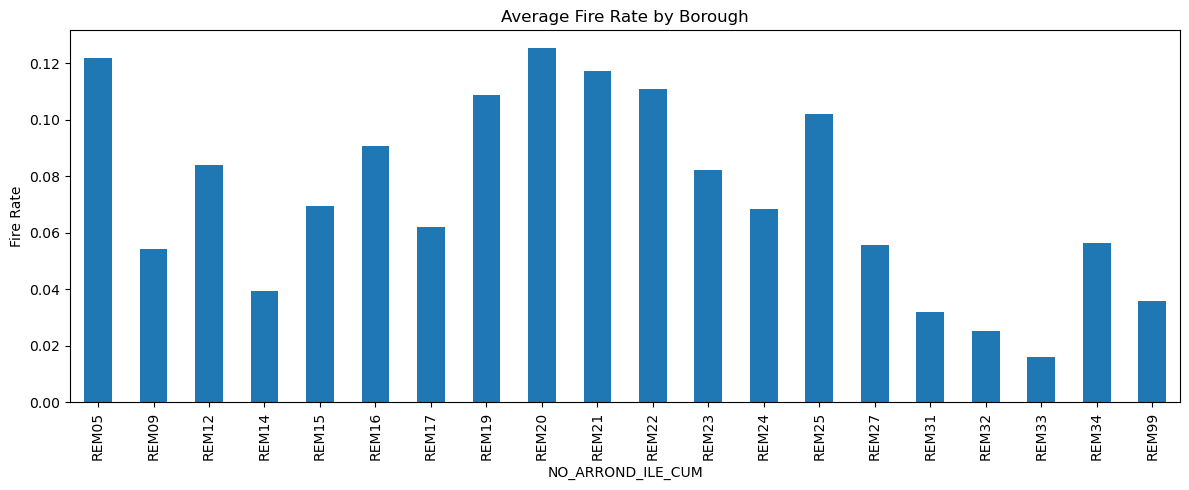

In [31]:
import matplotlib.pyplot as plt

zone_summary = final_df.groupby("NO_ARROND_ILE_CUM")[["FIRE_COUNT_LAST_YEAR_ZONE", "FIRE_RATE_ZONE"]].mean()

zone_summary["FIRE_RATE_ZONE"].plot(kind='bar', figsize=(12, 5), title="Average Fire Rate by Borough")
plt.ylabel("Fire Rate")
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import itertools

# 🔁 Step 1: Filter to valid fire events with dates
fires_with_date = final_df[(final_df["fire"] == True) & (final_df["fire_date"].notna())].copy()
fires_with_date["year_month"] = fires_with_date["fire_date"].dt.to_period("M").astype(str)

# ✅ Step 2: Count fires per (borough, month)
fire_counts_monthly = (
    fires_with_date.groupby(["NO_ARROND_ILE_CUM", "year_month"])
    .size()
    .reset_index(name="FIRE_COUNT_ZONE_MONTH")
)

# ✅ Step 3: Count buildings per borough
building_counts = (
    final_df.groupby("NO_ARROND_ILE_CUM")
    .size()
    .reset_index(name="BUILDING_COUNT")
)

# ✅ Step 4: Create all (borough, month) combinations
zones = final_df["NO_ARROND_ILE_CUM"].dropna().unique()
months = fires_with_date["year_month"].dropna().unique()
zone_month_pairs = pd.DataFrame(itertools.product(zones, months), columns=["NO_ARROND_ILE_CUM", "year_month"])

# ✅ Step 5: Merge & compute fire rate
zone_month_stats = zone_month_pairs.merge(fire_counts_monthly, on=["NO_ARROND_ILE_CUM", "year_month"], how="left")
zone_month_stats = zone_month_stats.merge(building_counts, on="NO_ARROND_ILE_CUM", how="left")
zone_month_stats["FIRE_COUNT_ZONE_MONTH"] = zone_month_stats["FIRE_COUNT_ZONE_MONTH"].fillna(0)
zone_month_stats["FIRE_RATE_ZONE_MONTH"] = zone_month_stats["FIRE_COUNT_ZONE_MONTH"] / zone_month_stats["BUILDING_COUNT"]

# ✅ Preview
zone_month_stats.sort_values(by=["NO_ARROND_ILE_CUM", "year_month"]).head()


,NO_ARROND_ILE_CUM,year_month,FIRE_COUNT_ZONE_MONTH,BUILDING_COUNT,FIRE_RATE_ZONE_MONTH
929,REM05,2020-01,77.0,8213,0.009375
925,REM05,2020-02,0.0,8213,0.000000
965,REM05,2020-03,63.0,8213,0.007671
961,REM05,2020-04,20.0,8213,0.002435
958,REM05,2020-05,118.0,8213,0.014367


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


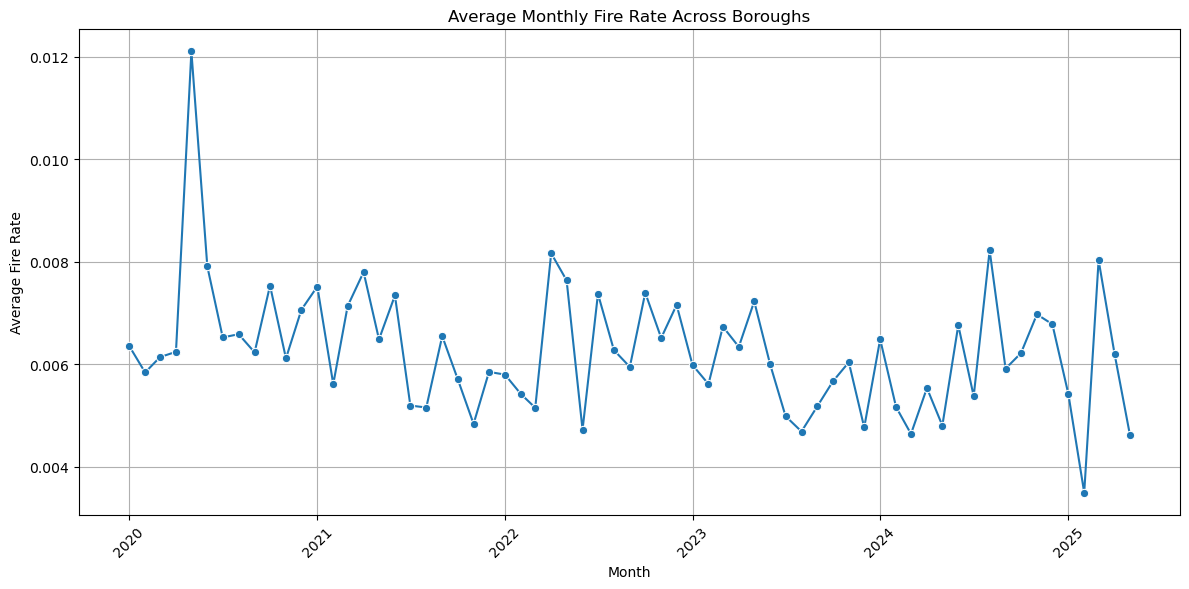

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load zone_month_stats if not already defined
zone_month_stats = pd.read_csv("zone_month_stats.csv") if "zone_month_stats" not in locals() else zone_month_stats

# Convert year_month to datetime for plotting
zone_month_stats["year_month"] = pd.to_datetime(zone_month_stats["year_month"])

# Compute average FIRE_RATE_ZONE_MONTH by month across all zones
monthly_avg = (
    zone_month_stats.groupby("year_month")["FIRE_RATE_ZONE_MONTH"]
    .mean()
    .reset_index(name="Avg_Fire_Rate")
)

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x="year_month", y="Avg_Fire_Rate", marker="o")
plt.title("Average Monthly Fire Rate Across Boroughs")
plt.xlabel("Month")
plt.ylabel("Average Fire Rate")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
